# Stanford Car Classification #

**Objective:** The goal is to predict the Make / model / year of a car on the image. 

**Dataset:** The dataset includes 8,144 training images and 8,041 testing images representing 196 classes of cars. 

**Literature review:** Literature review shows that **Deep Learning** models are primarily used. Random Forest is also seen. Since the dataset is not very large and task is similar to existing computer vision challenge (e.g. ImageNet), **transfer learning** based on pretrained models is a reasonable choice.



## Metrics##

- Accuracy

## Data preprocessing##

- Bounding box (already provided) : to remove irelevent background
- Data augmentation : to increase the amount of data by using techniques like cropping, padding, flipping, etc. The goal is to increase the robustness of the model and prevent the model from overfitting.

## Models ##
- Xception (the focus of this current notebook file): Xception stands for Extreme version of Inception model. With a modified depthwise separable convolution, it provides really strong performances for image datasets including ImageNet and JFT-FastEval14k.
- MobileNet

Let's start from loading necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model
from keras.applications.xception import Xception
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data Exploration

Define useful paths and parameters
- Number of classes (196 in this task)
- Size of image for the model (I chose 100 x 100 pixels considering the memory size and computational resource)

In [27]:
train_data_path = 'gdrive/My Drive/Colab Notebooks/stanford_car_dataset/car_data/car_data/train/'
test_data_path = 'gdrive/My Drive/Colab Notebooks/stanford_car_dataset/car_data/car_data/test/'
annotations_path = 'gdrive/My Drive/Colab Notebooks/stanford_car_dataset/'
number_of_classes = 196
img_width, img_height = 100, 100

Load the annotations (8144 items, each for one image):
- *class_ids* (0 to 195) corresponds to the Make Model Year of the car in an image
- *boxes* (x_min, y_min, x_max, y_max) is the bounding box apply on each image
- *fnames* is the image file name

In [28]:
annos_train = pd.read_csv(annotations_path+'anno_train.csv', header = None)
class_ids = []
boxes = []
fnames = []
for i in range(len(annos_train)) : 
    path = annos_train.iloc[i, 0]
    x_min, y_min, x_max, y_max = annos_train.iloc[i, 1:5]
    class_id = annos_train.iloc[i, 5]
    fnames.append(path)
    boxes.append([x_min, y_min, x_max, y_max])
    class_ids.append(class_id - 1)

Let's take a look at the class distribution

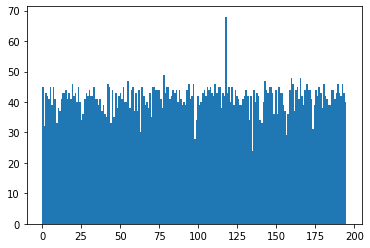

In [37]:
plt.hist(class_ids, bins=196)
plt.show()

One class seems to have more items than others, but most are in the same range and the dataset is considered as *balanced*. Let's define a Hashtable *name_map* to connect *class_id* and the *Make Model Year* text, such that the code can find the correct folder to load data images.

In [29]:
name_df = pd.read_csv(annotations_path+'names.csv', header = None)
name_map = {}
for i in range(len(name_df)):
    name_map[i] = name_df.iloc[i, 0]

Define a function to load and visualize data image with arguments:

- *class_ids*, *name_map*, *boxes* and *fnames* are explained in previous sections
- *show_image* chooses if the image (before and after applying bounding box) is plotted, default is not to show
- *length* chooses the number of loaded images, default is the entire dataset

In [14]:
def loadData(class_ids, name_map, boxes, fnames, data_path, length = len(class_ids), show_image = False):
    X_data = []
    for index in range(length):
        file_path = data_path+name_map[class_ids[index]].replace('/','-')+'/'+fnames[index].replace('/','-') # replace slash with hyphen to locate the correct image data folder
        x_min, y_min, x_max, y_max = boxes[index]
        img = cv2.imread(file_path)
        img_resize = cv2.resize(img[y_min:y_max, x_min:x_max], (img_width, img_height)) # resize the image for model input
        if show_image:
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(10, 4)
            ax1.imshow(img)
            ax2.imshow(img_resize)
            fig.suptitle('original image vs. bounded image '+str(index))
        X_data.append(img_resize)
    return X_data

Let's take a look at some examples of the original image and corresponding bounded image by the bounding box.

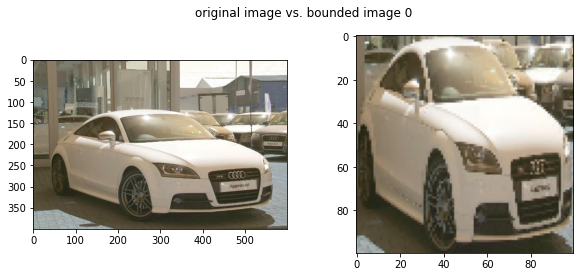

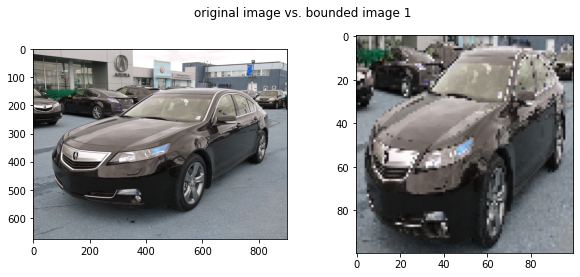

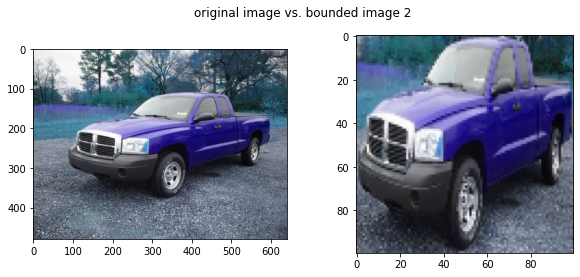

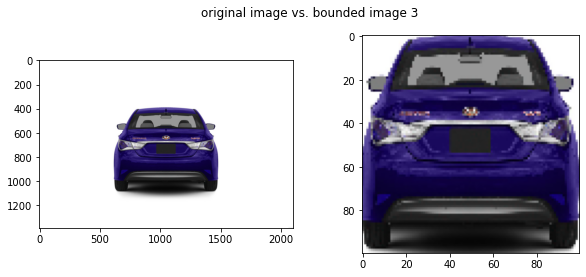

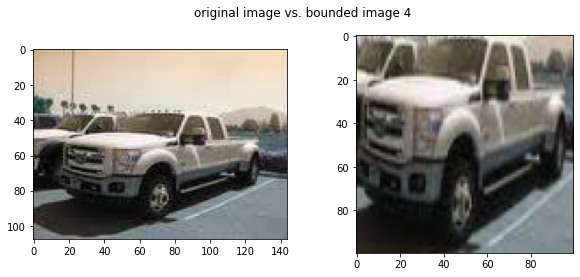

In [10]:
X_data = loadData(class_ids, name_map, boxes, fnames, train_data_path, length = 5, show_image = True)

Let's load the training data.

In [18]:
X_data = loadData(class_ids, name_map, boxes, fnames, train_data_path)

Loading image data is slow. It is safe to save the image data as a binary pickle file such that reloading is fast.

In [67]:
import pickle
with open(annotations_path+'X_data.pkl','wb') as dump_data:
    pickle.dump(X_data, dump_data)

In [30]:
import pickle
with open(annotations_path+'X_data.pkl','rb') as f:
    X_data = pickle.load(f)

## Model Buildup ##

Prepare the data for the model input. I decide to split the training set and preserve 25 percent for validation.

In [31]:
Xtrain, Xval, Ytrain, Yval = train_test_split(np.array(X_data, dtype=np.float64), class_ids, test_size=0.25, stratify = class_ids)
Xtrain /= 255 # normalize the train image data for model input
Xval /= 255 # normalize the validation image data for model input
Xtrain = Xtrain.reshape(len(Xtrain), img_width, img_height, 3)
Xval = Xval.reshape(len(Xval), img_width, img_height, 3)
Ytrain = np_utils.to_categorical(Ytrain, number_of_classes)
Yval = np_utils.to_categorical(Yval, number_of_classes)

Define the Image Data Generator, which generates batches of tensor image data with real-time data augmentation. Considering the car image could show different size and angle, I have applied **rotation, width and height shift, shear** and **zoom** operations.

In [32]:
gen = ImageDataGenerator(rotation_range=90, width_shift_range=0.3, shear_range=0.3,
                         height_shift_range=0.3, zoom_range=0.3, featurewise_std_normalization=False)
gen.fit(Xtrain)
train_generator = gen.flow(Xtrain, Ytrain, batch_size=64)
validation_generator = gen.flow(Xval, Yval, batch_size=64)

In this test I have chosen Xception model, and frozen hidden layers. Only the last dense layer is trainable. Here is a summary of the model.

In [47]:
img_input = Input(shape=(img_width, img_height, 3))
x = Xception(include_top=False, weights = 'imagenet' , input_tensor=img_input, input_shape=(img_width, img_height, 3), pooling="avg").output
x = Dense(number_of_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01))(x)
model = Model(inputs=img_input, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.0002), metrics=['accuracy'])
for layer in model.layers[:-1]:
   layer.trainable = False
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

### Training ###

Let's go! Train the model.

In [49]:
history = model.fit(train_generator, steps_per_epoch=len(Xtrain)//64, epochs=40, validation_data=validation_generator, validation_steps=len(Xval)//64)
model.save(annotations_path+"Xception_model")

Epoch 1/40
95/95 [==============================] - 28s 299ms/step - loss: 0.7447 - accuracy: 0.8936 - val_loss: 2.0654 - val_accuracy: 0.5428
Epoch 2/40
95/95 [==============================] - 28s 299ms/step - loss: 0.7170 - accuracy: 0.8999 - val_loss: 2.0802 - val_accuracy: 0.5484
Epoch 3/40
95/95 [==============================] - 29s 301ms/step - loss: 0.6981 - accuracy: 0.9118 - val_loss: 2.0452 - val_accuracy: 0.5570
Epoch 4/40
95/95 [==============================] - 29s 301ms/step - loss: 0.6661 - accuracy: 0.9161 - val_loss: 2.0399 - val_accuracy: 0.5610
Epoch 5/40
95/95 [==============================] - 29s 301ms/step - loss: 0.6386 - accuracy: 0.9153 - val_loss: 1.9845 - val_accuracy: 0.5897
Epoch 6/40
95/95 [==============================] - 29s 304ms/step - loss: 0.6386 - accuracy: 0.9181 - val_loss: 2.0614 - val_accuracy: 0.5660
Epoch 7/40
95/95 [==============================] - 29s 306ms/step - loss: 0.6161 - accuracy: 0.9227 - val_loss: 2.0137 - val_accuracy: 0.5736

Training were launched for 80 epoches. As we can see the training and validation accuracy have reached 96.59% and 58.27% respectively. Let's plot the training history for the last 40 epoches.

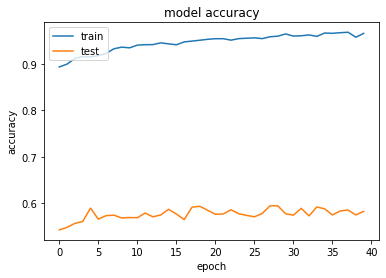

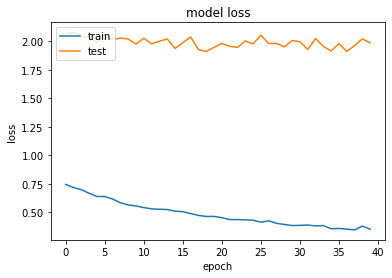

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

As we can see, for the last 40 epoches the validation accuracy stagnates. The final step is to evaluate the test dataset. I just apply the trained model the the dataset. The pipeline is the same as train the data. I won't explain is step by step, but will run it once to get the final score.

### Evaluation ###

In [33]:
annos_test = pd.read_csv(annotations_path+'anno_test.csv', header = None)
class_ids = []
boxes = []
fnames = []
for i in range(len(annos_test)) : 
    path = annos_test.iloc[i, 0]
    x_min, y_min, x_max, y_max = annos_test.iloc[i, 1:5]
    class_id = annos_test.iloc[i, 5]
    fnames.append(path)
    boxes.append([x_min, y_min, x_max, y_max])
    class_ids.append(class_id - 1)

In [15]:
Xfinal = loadData(class_ids, name_map, boxes, fnames, test_data_path)

In [18]:
import pickle
with open(annotations_path+'X_final.pkl','wb') as dump_data:
    pickle.dump(Xfinal, dump_data)

In [35]:
import pickle
with open(annotations_path+'X_final.pkl','rb') as f:
    Xfinal = pickle.load(f)

In [36]:
Xfinal = np.array(Xfinal, dtype=np.float64) / 255
Xfinal = np.array(Xfinal).reshape(len(Xfinal), img_width, img_height, 3)
Yfinal = np_utils.to_categorical(class_ids, number_of_classes)
score = model.evaluate(gen.standardize(Xfinal), Yfinal)
print('Test accuracy: {}'.format(score[1]))

252/252 [==============================] - 5s 21ms/step - loss: 1.8957 - accuracy: 0.6049
Test accuracy: 0.6048998832702637


As we can see, the model reaches an accuracy of 60.49% on the test set.

## Discussion ##

### a)	Train an image classifier to predict the Make model year of a car in an image. ###
Finished in previous sections. An observation is that Xception is less prone to overfit than MobileNetV2 model.

### b)	Briefly also explain how you could deploy your model in a productuction environment. ###

- General purpose: The models (classifier trained in a) and bounding box bounding box drawing tool trained in d)) together serve as car detector. The model is able to recogonize the **model mark year of cars** from an **arbitrary image**. From a business point of view, deployed as an application, and feed with collected image in a region, the model can **predict the car sale** as well as **automotive parts sale** in a region, which will help automotive industry comprises adjust their **supply allocation** and **marketing strategy** in advance.

- Deployment: The model could be pretrained and deployed as a web-application following the procedure https://towardsdatascience.com/deploying-keras-deep-learning-models-with-flask-5da4181436a2

- Scale: The model can be trained in real-time as the training dataset increases dynamically. the model could be deployed on a cloud platform (e.g. AWS, GCP, Azure) and connected to a file system to load dynamically local image (uploaded by user or scraped online by a crawler) and dynamically fine-tuning the model. The parameters can be stored in a database (e.g. SQL).

### c)	If you had more time, how could you improve this model?  ###
If I have more time, I'll consider the following improvement:
- Both Xception and MobileNetV2 models show an **overfitting**, I plan to try more techniques to avoid that, including adding **dropout** and adding more **regularization** in the hidden layer.
- Even with bounding box, the input image data still have **background noise**, which may cause overfitting. I can try to apply a **filter** to see the impact. I can start using a more simple CNN model then generalize to a pre-trained CNN model.
- Limited by traing time, both pretrained model have all the hidden layer **parameters** loaded from ImageNet and **frozen**. I would like to **unfreeze** the last block and further train it with current dataset.
- Try different **optimizers** such as SGD instead of Adam and make a **grid search** on learning rate and optimizer.

### d) ###
See separate notebook file